<a href="https://colab.research.google.com/github/andrebelem/pythonverse/blob/main/Extra%C3%A7%C3%A3o_de_dados_de_Precipita%C3%A7%C3%A3o_no_RS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div style="display: flex; align-items: center;">
    <img src="http://observatoriooceanografico.org/wp-content/uploads/elementor/thumbs/logo-o2-2-p31vla9ib17i85olifd4l1xk0e5lktrkal6u0s4c6o.png" style="width: 100px;"/>
    <h1 style="margin-left: 20px;">Extra√ß√£o de dados de precipita√ß√£o na nuvem do CESM-LENS (via AWS) no Rio Grande do Sul, Brasil.</h1>
</div>


Criado por [A.L. Bel√©m](mailto:andrebelem@id.uff.br) @ [Observat√≥rio Oceanogr√°fico](http://www.observatoiriooceanografico.uff.br) 2024 (vers√£o 1) <br>
Para maiores informa√ß√µes, acesse o [`pythonverse`](https://github.com/andrebelem/pythonverse) no meu github, e use a refer√™ncia [![DOI](https://zenodo.org/badge/342919527.svg)](https://zenodo.org/badge/latestdoi/342919527)

###### √öltima atualiza√ß√£o: 09 de Maio de 2024.

O objetivo deste notebook √© "extrair" dados do CESM-LENS na nuvem do NCAR na Amazon, sobre o Rio Grande do Sul, especificamente dados de precipita√ß√£o di√°ria m√°xima e precipita√ß√£o di√°ria, para os per√≠odos "hist√≥rico", "20th Century" e o cen√°rio do IPCC "RPC8.5", para depois fazer um processamento mais profundo posteriormente. Mais detalhes sobre essa vers√£o, procure os documentos no https://github.com/NCAR/cesm-lens-aws e fique atento para outros notebooks no `pythonverse`.<br>

**Note** que ao final eu gravo os resultados em uma √°rea do meu google drive, e portanto, estou montando o gdrive no meu google colab antes de iniciar. Adapte para suas necessidades.

O primeiro passo √© a instala√ß√£o de praticamente tudo que vou precisar aqui (abaixo).

In [1]:
# instalando o m√≥dulo para trabalhar com o bucket do AWS e mais algumas atualiza√ß√µes necess√°rias
# note que dependendo das vers√µes do COLAB, isso pode ser alterado. Vale a pena verificar a necessidade de
# reinstala√ß√£o do xarray completo (neste caso, para permitir flexibilidade com o cftime)
%%capture
!pip install s3fs
!pip install Intake-esm
!pip install -U xarray[complete] # reinstala todo o xarray (√∫til nessa vers√£o do colab por conta do cftime)

!pip install salem  # e tamb√©m com o salem e o rasterio
!pip install rasterio

!pip install cartopy # porque queremos fazer mapas legais.
# provavelmente o seu runtime ir√° reiniciar. N√£o tem problema ! √â normal isso acontecer.

In [2]:
# esta linha √© necess√°ria por conta de algumas atualiza√ß√µes. Talvez em um futuro seja desnecess√°rio.
!pip install pandas>=2.1.0 # uma pequena atualiza√ß√£o tamb√©m por conta do bucket da AWS

Agora, o segundo passo √© baixar os shapes das UGRHs que est√£o no meu github, mas podem ser obtidas no site da [ANA](https://metadados.snirh.gov.br/geonetwork/srv/eng/catalog.search#/metadata/985f8821-2da3-4108-85a9-95985b37f3fe).

In [3]:
!wget https://github.com/andrebelem/pythonverse/raw/main/datasets/SNIRH_UGRHs_2020.zip

--2024-05-10 14:48:27--  https://github.com/andrebelem/pythonverse/raw/main/datasets/SNIRH_UGRHs_2020.zip
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://media.githubusercontent.com/media/andrebelem/pythonverse/main/datasets/SNIRH_UGRHs_2020.zip [following]
--2024-05-10 14:48:27--  https://media.githubusercontent.com/media/andrebelem/pythonverse/main/datasets/SNIRH_UGRHs_2020.zip
Resolving media.githubusercontent.com (media.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to media.githubusercontent.com (media.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13113509 (13M) [application/zip]
Saving to: ‚ÄòSNIRH_UGRHs_2020.zip‚Äô

SNIRH_UGRHs_2020.zi 100%[===================>]  12.51M  --.-KB/s    in 0.1s    

2024-05-10 14:48:28 (96.0 MB/s) - ‚Ä

In [4]:
# vamos explorar esse arquivo e separar as UGRHs que comp√µem o RS, ou seja,
# apenas aquelas que est√£o abaixo de 26¬∞S de latitude

import geopandas as gpd
ugrh = gpd.read_file('SNIRH_UGRHs_2020.zip')

rs = ugrh[ugrh.bounds['maxy'] < -26]
# para facilitar a extra√ß√£o:
sul_ugrh = rs.dissolve()
print(f'Bounds:{sul_ugrh.bounds}')

Bounds:        minx       miny       maxx       maxy
0 -57.643885 -33.752081 -49.280653 -26.241184


Agora que temos um shapefile para recortar nossos datasets, vamos obter os dados do CESM-LENS.

## CESM-LENS na nuvem (AWS S3)

Aqui vou obter os campos do CESM-Large Ensemble para os experimentos "20C" (ou 20 century: 1920 √† 2005) e "HIST" que √© per√≠odo hist√≥rico de 1850-1920, al√©m do cen√°rio RCP8.5 (at√© 2100). Veja abaixo que estou interessado <u>**apenas**</u> na precipita√ß√£o m√°xima (ou na precipita√ß√£o di√°ria, dependendo do dataset). Note ainda que o procedimento aqui √© para separar os datasets e grava-los em netcdf, j√° que s√£o campos muito grandes e os "chunks" de tempo demoram muito para serem executados se fizessemos uma computa√ß√£o na nuvem. Obviamente eu j√° poderia fazer toda a an√°lise aqui, mas preferi primeiro extrair, gravar e depois processar em outro notebook. Voc√™ pode fazer o mesmo para qualquer vari√°vel. Use sua criatividade.

**Detalhe importante**: Como reinstalamos o xarray, ele n√£o reconhece de primeira o arquivo METADATA. Note ent√£o que tenho que rodar a c√©lula abaixo 2x (!)

In [6]:
# de alguma forma, o python n√£o reconhece em uma primeira rodada o arquivo METADATA.
# Rode 2x essa c√©lula !
import intake
col = intake.open_esm_datastore("https://raw.githubusercontent.com/NCAR/cesm-lens-aws/main/intake-catalogs/aws-cesm1-le.json")

In [7]:
# estou interessado na vari√°vel que cont√©m a "taxa de precipita√ß√£o". vou listar todas as op√ß√µes aqui
col.df[(col.df['long_name'].str.contains('precipitation rate', na=False))&(col.df['variable']=='PRECTMX')]

variable                                          long_name component  \
12  PRECTMX  maximum (convective and large-scale) precipita...       atm   
54  PRECTMX  maximum (convective and large-scale) precipita...       atm   

   experiment frequency  vertical_levels spatial_domain units  \
12        20C     daily              1.0         global   m/s   
54       HIST     daily              1.0         global   m/s   

             start_time             end_time  \
12  1920-01-01 12:00:00  2005-12-31 12:00:00   
54  1850-01-01 12:00:00  1919-12-31 12:00:00   

                                                 path  
12  s3://ncar-cesm-lens/atm/daily/cesmLE-20C-PRECT...  
54  s3://ncar-cesm-lens/atm/daily/cesmLE-HIST-PREC...

In [8]:
# e o mesmo para o experimento RCP8.5
col.df[(col.df['long_name'].str.contains('precipitation rate', na=False))&(col.df['experiment'].str.contains('RCP'))]

variable                                          long_name component  \
74     PRECL  large-scale (stable) precipitation rate (liq +...       atm   
77     PRECT  total (convective and large-scale) precipitati...       atm   
100    PRECT  total (convective and large-scale) precipitati...       atm   
113    PRECT  total (convective and large-scale) precipitati...       atm   
205    PRECC          convective precipitation rate (liq + ice)       atm   
206    PRECL  large-scale (stable) precipitation rate (liq +...       atm   

    experiment          frequency  vertical_levels spatial_domain units  \
74       RCP85              daily              1.0         global   m/s   
77       RCP85              daily              1.0         global   m/s   
100      RCP85  hourly6-2026-2035              1.0         global   m/s   
113      RCP85  hourly6-2071-2080              1.0         global   m/s   
205      RCP85            monthly              1.0         global   m/s   
206      RCP85            monthly              1.0         global   m/s   

              start_time             end_time  \
74   2006-01-01 12:00:00  2100-12-31 12:00:00   
77   2006-01-01 12:00:00  2100-12-31 12:00:00   
100  2026-01-01 00:00:00  2036-01-01 00:00:00   
113  2071-01-01 00:00:00  2081-01-01 00:00:00   
205  2006-01-16 12:00:00  2100-12-16 12:00:00   
206  2006-01-16 12:00:00  2100-12-16 12:00:00   

                                                  path  
74   s3://ncar-cesm-lens/atm/daily/cesmLE-RCP85-PRE...  
77   s3://ncar-cesm-lens/atm/daily/cesmLE-RCP85-PRE...  
100  s3://ncar-cesm-lens/atm/hourly6-2026-2035/cesm...  
113  s3://ncar-cesm-lens/atm/hourly6-2071-2080/cesm...  
205  s3://ncar-cesm-lens/atm/monthly/cesmLE-RCP85-P...  
206  s3://ncar-cesm-lens/atm/monthly/cesmLE-RCP85-P...

Note que h√° uma vari√°vel chamada PRECTMX que √© o "maximum (convective and large-scale) precipitation rate". J√° para os experimentos de RCP, vou usar a vari√°vel PRECT. Voc√™ pode ter uma ideia melhor das vari√°veis olhando aqui https://www.cesm.ucar.edu/community-projects/lens2/output-variables.

In [9]:
# vou fazer um subset onde separo apenas o que eu quero, frequ√™ncia di√°ria
col_subset = col.search(experiment=["HIST","20C"], frequency="daily", variable=["PRECTMX"])
col_subset2 = col.search(experiment=["RCP85"], frequency="daily", variable=["PRECT"])
# agora vou criar datasets do meu subset
dsets = col_subset.to_dataset_dict(zarr_kwargs={"consolidated": True}, storage_options={"anon": True})
dsets2 = col_subset2.to_dataset_dict(zarr_kwargs={"consolidated": True}, storage_options={"anon": True})


--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.frequency'

--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.frequency'


In [10]:
# Apenas para verificar, os dados est√£o aqui:
print(dsets.keys(),dsets2.keys())

dict_keys(['atm.20C.daily', 'atm.HIST.daily']) dict_keys(['atm.RCP85.daily'])


In [11]:
# compatibiliza as longitudes entre o shape e o dataset com uma margem de 1 grau
lons = slice(sul_ugrh.bounds['minx'].values[0]+360-1, sul_ugrh.bounds['maxx'].values[0]+360+1)
lats = slice(sul_ugrh.bounds['miny'].values[0]-1, sul_ugrh.bounds['maxy'].values[0]+1)

# a minha estrat√©gia aqui foi obter um campo um pouco maior do que os bounds do meu shapefile. No processamento isso ser√° importante.

In [12]:
# extraindo o dataset de cada experimento dentro do que precisamos
# note que estou compatibilizando as longitudes entre o shape e o dataset
ds_hist = dsets['atm.HIST.daily'].sel(lon=lons,lat=lats)
ds_20C = dsets['atm.20C.daily'].sel(lon=lons,lat=lats)
ds_rcp85 = dsets2['atm.RCP85.daily'].sel(lon=lons,lat=lats)

In [13]:
# Converter as longitudes de 0-360 para -180 a +180
ds_20C['lon'] = ((ds_20C['lon'] + 180) % 360) - 180
ds_hist['lon'] = ((ds_hist['lon'] + 180) % 360) - 180
ds_rcp85['lon'] = ((ds_rcp85['lon'] + 180) % 360) - 180

In [14]:
# agora vamos passar tudo que j√° fizemos do dask para a mem√≥ria. Isso pode demorar um pouco !
# ##### CAUTELA #### cada execu√ß√£o pode demorar aprox. 1h2-1h30
from dask.diagnostics import ProgressBar
ProgressBar().register()

O `Dask` √© uma biblioteca Python projetada para processamento paralelo e distribu√≠do de grandes conjuntos de dados. Quando voc√™ executa opera√ß√µes em um objeto `Xarray` com o backend `Dask`, como por exemplo, filtragem, agrega√ß√£o ou c√°lculos complexos, essas opera√ß√µes n√£o s√£o executadas imediatamente. Em vez disso, o `Dask` constr√≥i um gr√°fico de tarefas que representa as opera√ß√µes a serem realizadas nos dados. √â o que chamamos de "lazy evaluation", o que significa que as opera√ß√µes n√£o s√£o realizadas at√© que seja necess√°rio obter o resultado final. Por um lado, isso √© bom para trabalhar com grandes volumes de dados, mas se voc√™ est√° fazendo uma "explora√ß√£o" de dados, essa demora pode prejudicar bastante o seu trabalho.

Quando voc√™ chama o m√©todo `.load()` em um objeto `Xarray` com o backend `Dask`, isso atua como um gatilho para iniciar a execu√ß√£o real das opera√ß√µes pendentes e carregar os resultados na mem√≥ria. Ao chamar `.load()`, voc√™ instrui o `Dask` a realizar as opera√ß√µes necess√°rias para calcular o resultado e carregar os dados calculados na mem√≥ria, convertendo-os em um objeto `Xarray` regular. Ent√£o, **voc√™ tem que ter certeza do que est√° fazendo**.

In [15]:
ds_20C.load() # executa para 20C

[########################################] | 100% Completed | 53m 0s


<xarray.Dataset> Size: 403MB
Dimensions:    (member_id: 40, time: 31390, lat: 10, lon: 8, nbnd: 2)
Coordinates:
  * lat        (lat) float64 80B -34.4 -33.46 -32.51 ... -27.8 -26.86 -25.92
  * lon        (lon) float64 64B -57.5 -56.25 -55.0 ... -51.25 -50.0 -48.75
  * member_id  (member_id) int64 320B 1 2 3 4 5 6 7 ... 35 101 102 103 104 105
  * time       (time) object 251kB 1920-01-01 12:00:00 ... 2005-12-31 12:00:00
    time_bnds  (time, nbnd) object 502kB 1920-01-01 00:00:00 ... 2006-01-01 0...
Dimensions without coordinates: nbnd
Data variables:
    PRECTMX    (member_id, time, lat, lon) float32 402MB 4.925e-08 ... 8.146e-08
Attributes: (12/25)
    Conventions:                       CF-1.0
    NCO:                               4.4.2
    Version:                           $Name$
    important_note:                    This data is part of the project 'Blin...
    initial_file:                      b.e11.B20TRC5CNBDRD.f09_g16.001.cam.i....
    logname:                           mudryk
    ...                                ...
    intake_esm_attrs:units:            m/s
    intake_esm_attrs:start_time:       1920-01-01 12:00:00
    intake_esm_attrs:end_time:         2005-12-31 12:00:00
    intake_esm_attrs:path:             s3://ncar-cesm-lens/atm/daily/cesmLE-2...
    intake_esm_attrs:_data_format_:    zarr
    intake_esm_dataset_key:            atm.20C.daily

In [16]:
ds_hist.load() # executa para o hist (que √© bem mais r√°pido pois √© apenas 1 membro)

[########################################] | 100% Completed | 76.33 s


<xarray.Dataset> Size: 9MB
Dimensions:    (time: 25550, lat: 10, lon: 8, nbnd: 2)
Coordinates:
  * lat        (lat) float64 80B -34.4 -33.46 -32.51 ... -27.8 -26.86 -25.92
  * lon        (lon) float64 64B -57.5 -56.25 -55.0 ... -51.25 -50.0 -48.75
    member_id  int64 8B 1
  * time       (time) object 204kB 1850-01-01 12:00:00 ... 1919-12-31 12:00:00
    time_bnds  (time, nbnd) object 409kB 1850-01-01 00:00:00 ... 1920-01-01 0...
Dimensions without coordinates: nbnd
Data variables:
    PRECTMX    (time, lat, lon) float32 8MB 2.213e-13 1.322e-09 ... 1.831e-08
Attributes: (12/25)
    Conventions:                       CF-1.0
    NCO:                               4.4.2
    Version:                           $Name$
    important_note:                    This data is part of the project 'Blin...
    initial_file:                      b.e11.B20TRC5CNBDRD.f09_g16.001.cam.i....
    logname:                           mudryk
    ...                                ...
    intake_esm_attrs:units:            m/s
    intake_esm_attrs:start_time:       1850-01-01 12:00:00
    intake_esm_attrs:end_time:         1919-12-31 12:00:00
    intake_esm_attrs:path:             s3://ncar-cesm-lens/atm/daily/cesmLE-H...
    intake_esm_attrs:_data_format_:    zarr
    intake_esm_dataset_key:            atm.HIST.daily

In [17]:
ds_rcp85.load() # executa para o rcp8.5 (que tamb√©m √© longo, com 105 membros)

[########################################] | 100% Completed | 61m 40s


<xarray.Dataset> Size: 445MB
Dimensions:    (member_id: 40, time: 34675, lat: 10, lon: 8, nbnd: 2)
Coordinates:
  * lat        (lat) float64 80B -34.4 -33.46 -32.51 ... -27.8 -26.86 -25.92
  * lon        (lon) float64 64B -57.5 -56.25 -55.0 ... -51.25 -50.0 -48.75
  * member_id  (member_id) int64 320B 1 2 3 4 5 6 7 ... 35 101 102 103 104 105
  * time       (time) object 277kB 2006-01-01 12:00:00 ... 2100-12-31 12:00:00
    time_bnds  (time, nbnd) object 555kB 2006-01-01 00:00:00 ... 2101-01-01 0...
Dimensions without coordinates: nbnd
Data variables:
    PRECT      (member_id, time, lat, lon) float32 444MB 2.779e-12 ... 3.297e-07
Attributes: (12/26)
    Conventions:                       CF-1.0
    NCO:                               4.4.2
    Version:                           $Name$
    host:                              tcs-f02n07
    important_note:                    This data is part of the project 'Blin...
    initial_file:                      b.e11.B20TRC5CNBDRD.f09_g16.105.cam.i....
    ...                                ...
    intake_esm_attrs:units:            m/s
    intake_esm_attrs:start_time:       2006-01-01 12:00:00
    intake_esm_attrs:end_time:         2100-12-31 12:00:00
    intake_esm_attrs:path:             s3://ncar-cesm-lens/atm/daily/cesmLE-R...
    intake_esm_attrs:_data_format_:    zarr
    intake_esm_dataset_key:            atm.RCP85.daily

In [18]:
# agora eu gravo todos os meus resultados em netcdf
ds_20C.to_netcdf('ds_20_RS.nc')
ds_hist.to_netcdf('ds_hist_RS.nc')
ds_rcp85.to_netcdf('ds_rcp85_RS.nc')

# e transfiro para minha √°rea no google drive. Adapte aqui para sua √°rea se desejar.
!mv *.nc /content/drive/MyDrive/01_Pesquisa/00_PrecipRS/.

A partir do momento que voc√™ tem isso gravado, as possibilidades de pesquisa s√£o ilimitadas. Se voc√™ n√£o gravar o resultado, ter√° que perder esse tempo (~2h) cada vez que tentar fazer algo aqui no google colab.

# Algumas dicas adicionais

Para deixar o processo um pouco mais interessante, vou produzir um mapa. Neste caso, vou fazer a m√©dia do m√°ximo de precipita√ß√£o entre todos os membros e todos os anos, <u>apenas para o mes de maio</u>, do dataset `20C`. Vou aproveitar tamb√©m para converter as unidades para mm/dia.

In [19]:
# note que a unidade de medida desses campos s√£o em m/s (fluxo de √°gua)
# portanto, para converter em mm/dia eu vou usar a fun√ß√£o abaixo
def mm_per_day(precip):
    ''' Esta fun√ß√£o converte a precipita√ß√£o dada em m/s para mm/dia (mais condizente com o que conhecemos de meteorologia)
        Basicamente, 1 metro = 1000 milimetros, e dia = 86400 segundos.
    '''
    return precip * 1000 * 86400

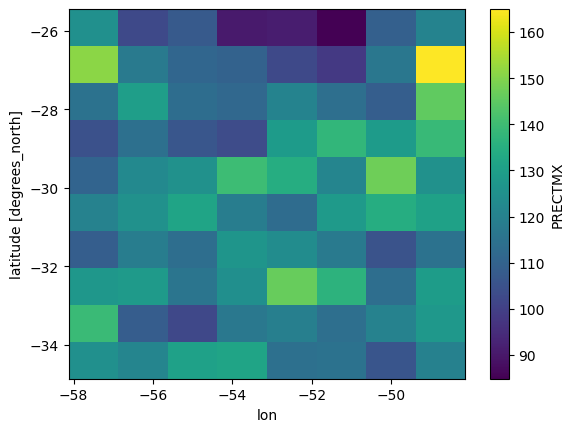

In [20]:
# construindo um campo apenas para fazer um plot
may_median = ds_20C.sel(time=ds_20C['time.month'] == 5).PRECTMX.max(dim=['time','member_id']).pipe(mm_per_day)
may_median.plot() # caso voc√™ queira ver como ficou

**CAUTELA**: Este √© um plot simples, mostrando apenas <u>o m√°ximo</u> em cada ponto de grade. Aqui vou plotar um mapa decente, com escala de cores, que corresponde a precipita√ß√£o m√°xima, entre todos os membros e todos os anos, para o mes de maio, entre 1920 e 2005 (dataset 20C) do CESM-LENS. Note que os valores n√£o tem uma distribui√ß√£o cont√≠nua, justamente porque este √© um pseudo-*heatmap* e n√£o uma medida essencialmente estat√≠stica.

/usr/local/lib/python3.10/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_cultural/ne_50m_admin_1_states_provinces_lines.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.10/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_cultural/ne_50m_admin_0_countries.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.10/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


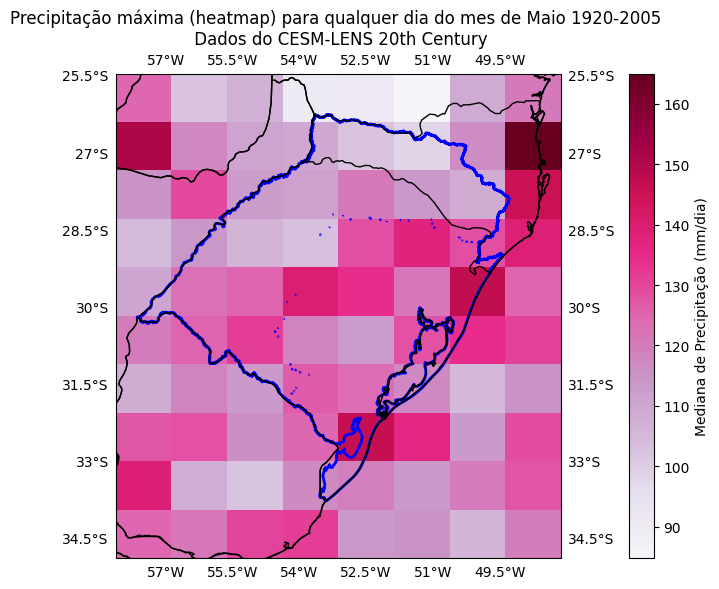

In [21]:
# Fazendo um plot "decente"
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
from cartopy.feature import NaturalEarthFeature, LAND, COASTLINE

plt.figure(figsize=(14,6))
ax = plt.axes(projection=ccrs.PlateCarree())

plot = may_median.plot(ax=ax,
                transform=ccrs.PlateCarree(), x='lon', y='lat',
                cmap='PuRd',add_colorbar=False)
# t√≠tulo do plot
plt.title('Precipita√ß√£o m√°xima (heatmap) para qualquer dia do mes de Maio 1920-2005 \n Dados do CESM-LENS 20th Century')
cbar = plt.colorbar(plot, ax=ax, orientation='vertical')
cbar.set_label('Mediana de Precipita√ß√£o (mm/dia)')

states = NaturalEarthFeature(category='cultural', scale='50m', facecolor='none',
                             name='admin_1_states_provinces_lines')
contries = NaturalEarthFeature(category='cultural', scale='50m', facecolor='none',
                             name='admin_0_countries')

ax.add_feature(states, facecolor='none', edgecolor='black')
ax.add_feature(contries, facecolor='none', edgecolor='black')
ax.gridlines(draw_labels=True,crs=ccrs.PlateCarree(),x_inline=False,y_inline=False,color = "None")

# aqui plota o shapefile das UGRHs do sul.
sul_ugrh.geometry.plot(ax=ax,facecolor='none',edgecolor='blue',linewidth=2,label='Limite das UGRHs')

ax.coastlines()

plt.tight_layout()
plt.show()

Este √© um excelente exemplo de como trabalhar com dados grandes na nuvem. O tempo total para rodar este notebook √© basicamente condicionado pelo tempo dos `.load()`s dos datasets (aqui: >2h).

Boa sorte !

**PS**: Se voc√™ gostou, voc√™ pode [comprar um caf√© para mim !](https://www.buymeacoffee.com/andrebelem)üòâ
